**Link to github repository:**

**Group members contribution:**


# Assignment 1 

In [2]:
# Import libraries
from bs4 import BeautifulSoup ##A package to work with HTML data
import requests #A package to make HTTP requests
import pandas as pd
import numpy as np
import re
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

#### **Part 1: Using web-scraping to gather data**

*1. Inspect the HTML of the pages above and use web-scraping to get the set of participants in 2019. Share your code and add comments to guide us through it.*


In [ ]:
# 2019 Posters
LINK = "https://2019.ic2s2.org/posters/"
r = requests.get(LINK) 
soup = BeautifulSoup(r.content) 
list = soup.find("article",{"class":"section section-text"})

# find all the ul tags
list_items = list.find_all(r'ul')

# find all the li tags
names = list_items[1].find_all('li')

thurs = []
# iterate through the list of names
for tr in names[0:]:
    # split the text by \xa0 and take the first element
    names1 = tr.text.split("\xa0")[0]
    # replace the word "and" with a comma
    names12 = names1.replace(' and ', ', ')
    # split the text by comma
    row = names12.split(", ")
    # append the list to the thurs list
    thurs = thurs + row  

names = list_items[2].find_all('li')

fri = []
# do the same for friday
for tr in names[0:]:
    names1 = tr.text.split("\xa0")[0]
    names12 = names1.replace(' and ', ', ')
    row = names12.split(", ")
    fri = fri + row  

# combine the two lists of authors from thursday and friday
authors_2019_p = np.unique(thurs + fri)

# 2019 Oral Presentations
LINK = "https://2019.ic2s2.org/oral-presentations/"
r = requests.get(LINK)

html = r.text
soup = BeautifulSoup(html, 'html.parser')

# find all the p tags
p_tags = soup.find_all("p")

# regular expression to find the authors
re_match_auth = r"[–|,|\s]?\s([A-Z][a-z]+\s\w?.?\s?[A-Z][a-z]+)[–|.|,|]"
re_bold = r"<p><strong>"

authors = []

for p in p_tags:
    # find the authors in bold
    if re.search(re_bold, str(p)):
        # find the authors
        author = re.findall(re_match_auth, str(p))
        
        authors.append(author)


# iterate through the sublist using List comprehension
authors = [element for innerList in authors for element in innerList]
authors_2019_o = np.unique(authors)

# save the list of authors in a csv file
authors_2019 = np.append(authors_2019_p, authors_2019_o) 
authors_2019_unique = np.unique(authors_2019)
all_authors_2019 = pd.DataFrame()
all_authors_2019["names"] = authors_2019_unique


# to csv
all_authors_2019.to_csv("all_authors_2019_ori.csv", index=False)

*2. How many unique researchers you got in 2019?*

In [74]:
# read the all authors csv with some errors removed
all_authors_2019 = pd.read_csv("all_authors_2019.csv")
# get unique authors
unique_authors = all_authors_2019["names"].unique()

print("Number of unique authors in 2019:", len(unique_authors))

Number of unique authors in 2019: 838


*3. Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?*

Due to incosistensy in the design of the webpages, some presentation names were included in the list of authors. These were removed manually. This could have been included in the code. 

hmmmm ????? question mark

#### **Part 2: Getting data from the Semantic Scholar API**

1. *Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.*

We used 838 unique author names from 2019 to retrieve their author ids and their collaborators. This gave us a total of: 48.054 unique author ids to retrieve the data from the API and to create the 3 dataframes. 

Due to limitations including maximum number of requests for the API and time constraints, not all of the 838 author names were able to be retrieved from the API. However, 48.054 seems like an adequate amount to work with further on.  

In [75]:
# First, read the data needed to retrieve the three dataframes from the API
# read author ids 2019 csv 
author_ids_unique_2019 = pd.read_csv("author_ids_unique_2019.csv")

# Remove nan, covert to int and string
author_ids_unique_2019 = author_ids_unique_2019.dropna().astype(int).astype(str)

# Get first column
author_ids_unique_2019 = author_ids_unique_2019.iloc[:,0].tolist()

# print len of unique authors
print("Number of unique authors in 2019 with ids:", len(author_ids_unique_2019))

# print first 10 authors
print("The author IDs are in a list of strings:", author_ids_unique_2019[0:10])


Number of unique authors in 2019 with ids: 48054
The author IDs are in a list of strings: ['41173434', '50593657', '2137966406', '67136446', '2054106142', '40067495', '2066146609', '3840131', '148190842', '2109141879']


2. *Share the code you have used to solve the exercise above.*

The code to create the three datasets below:


In [ ]:
# set up URL for API
BASE_URL = "https://api.semanticscholar.org/graph/v1/author/batch?fields=authorId,name,aliases,citationCount,papers,papers.fieldsOfStudy,papers.year,papers.citationCount,papers.externalIds,papers.abstract,papers.title,papers.authors"
# create 3 dataframes
df_author = pd.DataFrame(columns= ["authorId", "name", "aliases", "citationCount", "papers"])
df_paper = pd.DataFrame(columns= ["paper_id", "title", "year", "external_ids", "CitationCount", "Fieldofstudy", "authorIds"])
df_paper_abstract = pd.DataFrame(columns= ["paperId", "abstract"])

# loop through all author ids
for i in tqdm(range(0,len(author_ids_unique_2019),10)):
    batch_id = {"ids": author_ids_unique_2019[i:i+10]}
    r = requests.post(BASE_URL, json=batch_id)  
    data = r.json()
    # loop through all authors in the batch    
    for author in data:

        fields_of_study = []
        
        # loop through all papers of the author
        for paper in author.get("papers", {}):
            df_paper = df_paper.append({
                "paper_id":paper["paperId"],
                "title":paper["title"],
                "year":paper.get("year", None),
                "external_ids":paper.get("externalIds", {}).get("DOI", None),
                "CitationCount":paper.get("citationCount", 0),
                "Fieldofstudy":paper.get("fieldsOfStudy", [])[0] if paper.get("fieldsOfStudy", []) != None else None,
                "authorIds": [author.get("authorId", None) for author in paper.get("authors", [])],
                }, ignore_index=True)
            
            # check if the paper has an abstract
            if "abstract" in paper.keys():
                # append the paper id and abstract to the dataframe
                df_paper_abstract = df_paper_abstract.append({
                    "paperId": paper.get("paperId", None),
                    "abstract": paper.get("abstract", None)
                }, ignore_index=True)

            fields_of_study.append(paper.get("fieldsOfStudy", [])[0] if paper.get("fieldsOfStudy", []) != None else "None")

        # append the author to the dataframe
        df_author = df_author.append({
        "authorId": author["authorId"],
        "name": author.get("name", ""),
        "aliases": author.get("aliases", []),
        "citationCount": author.get("citationCount", 0),
        "fieldsOfStudy": max(set(fields_of_study)) if len(fields_of_study) > 0 else None
    }, ignore_index=True)
    

In [ ]:
# save the 3 dataframes to csv
df_author.to_csv("author_dataset.csv", index=False)
df_paper.to_csv("paper_dataset.csv", index=False)
df_paper_abstract.to_csv("paper_abstract_dataset.csv", index=False)

In [80]:
# read the 3 dataframes
df_author = pd.read_csv("author_dataset.csv")
df_paper = pd.read_csv("paper_dataset.csv")

print("The length of the final Author dataframe is:", len(df_author))
print("The length of the final Paper dataset is:", len(df_paper))

The length of the final Author dataframe is: 1694
The length of the final Paper dataset is: 142283


3. *How long is your final Author dataframe? How long is your final Paper dataframe?*

The length of the final Author dataframe is: 1694

The length of the final Paper dataset is: 142283

#### **Part 3: Law of large numbers**

**Gaussian Distribution**

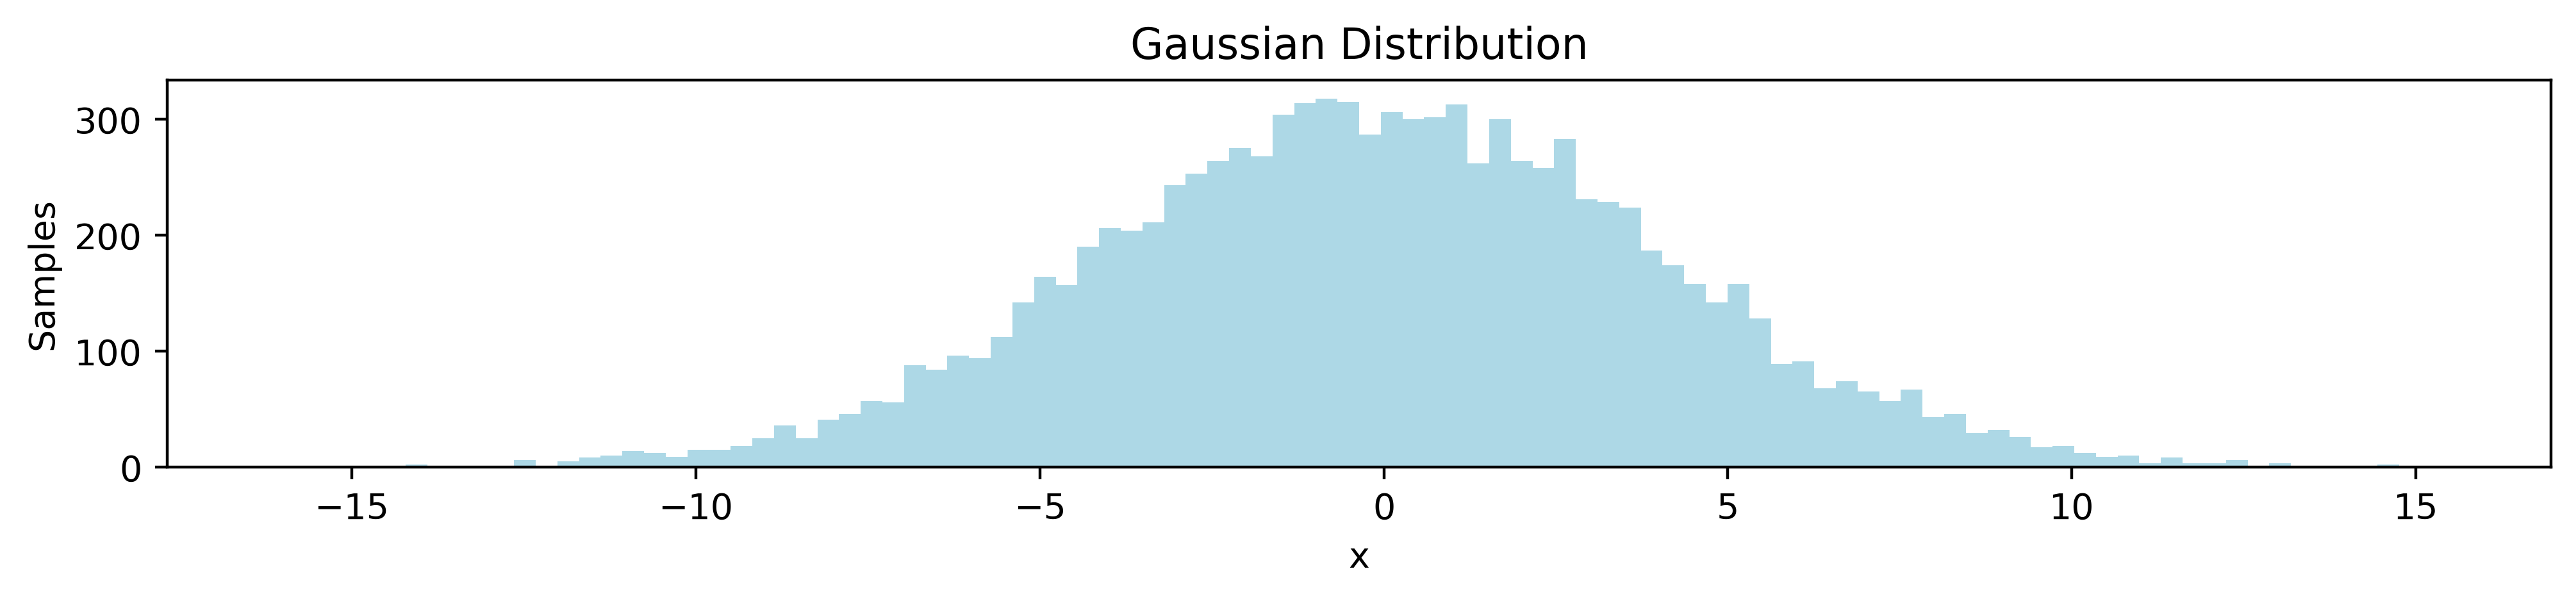

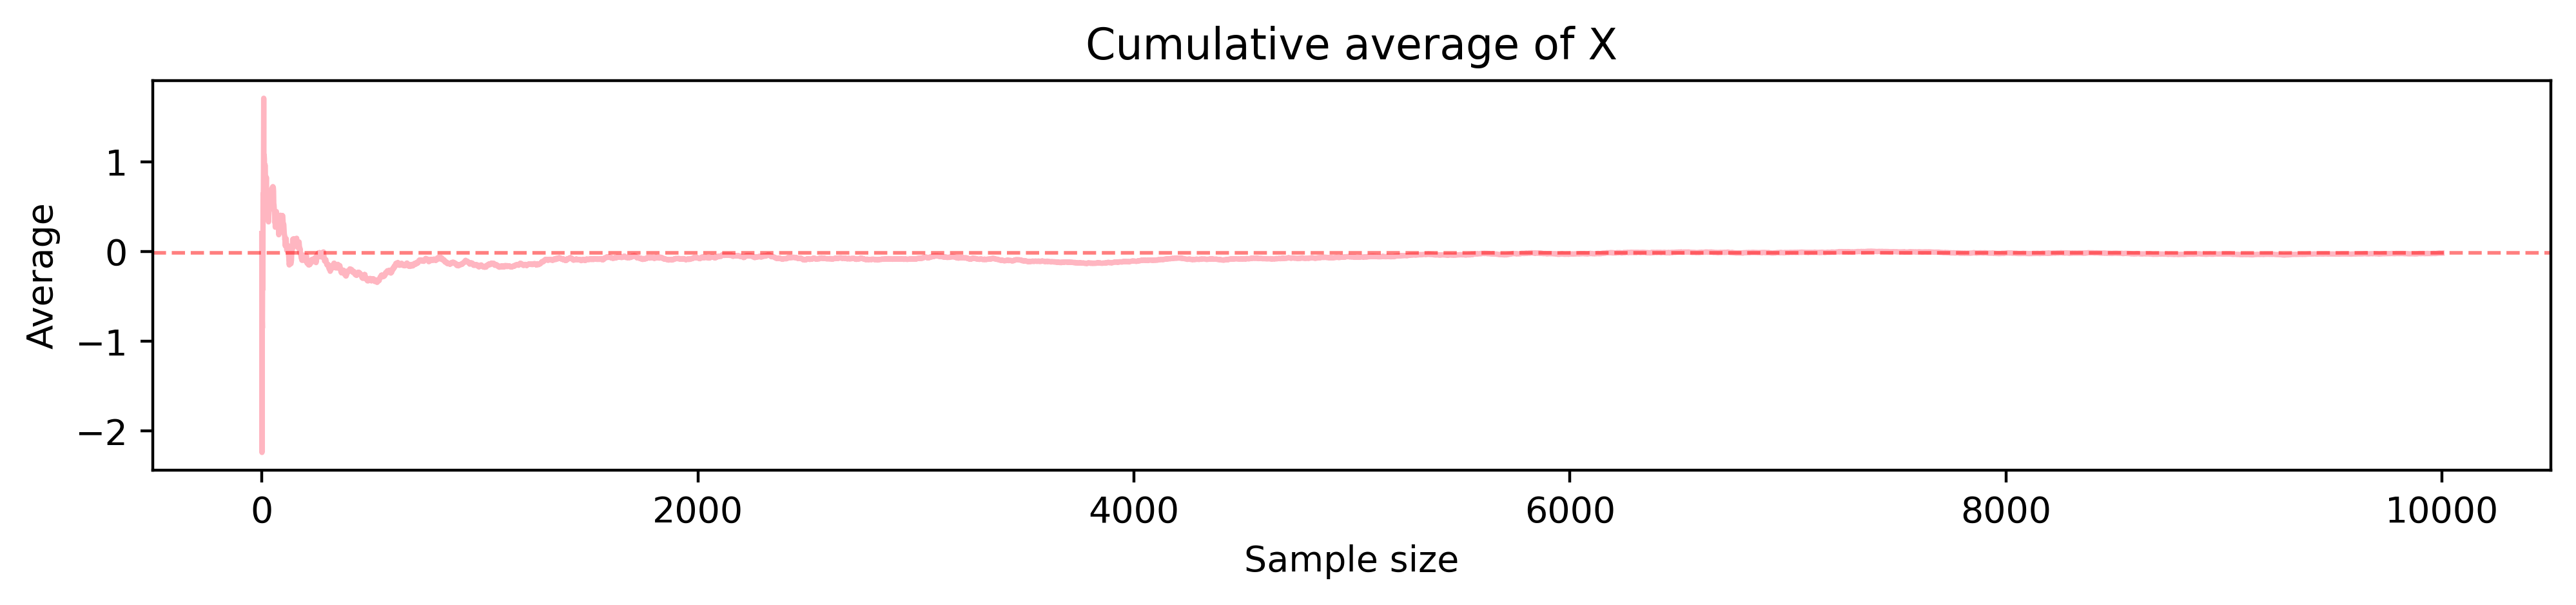

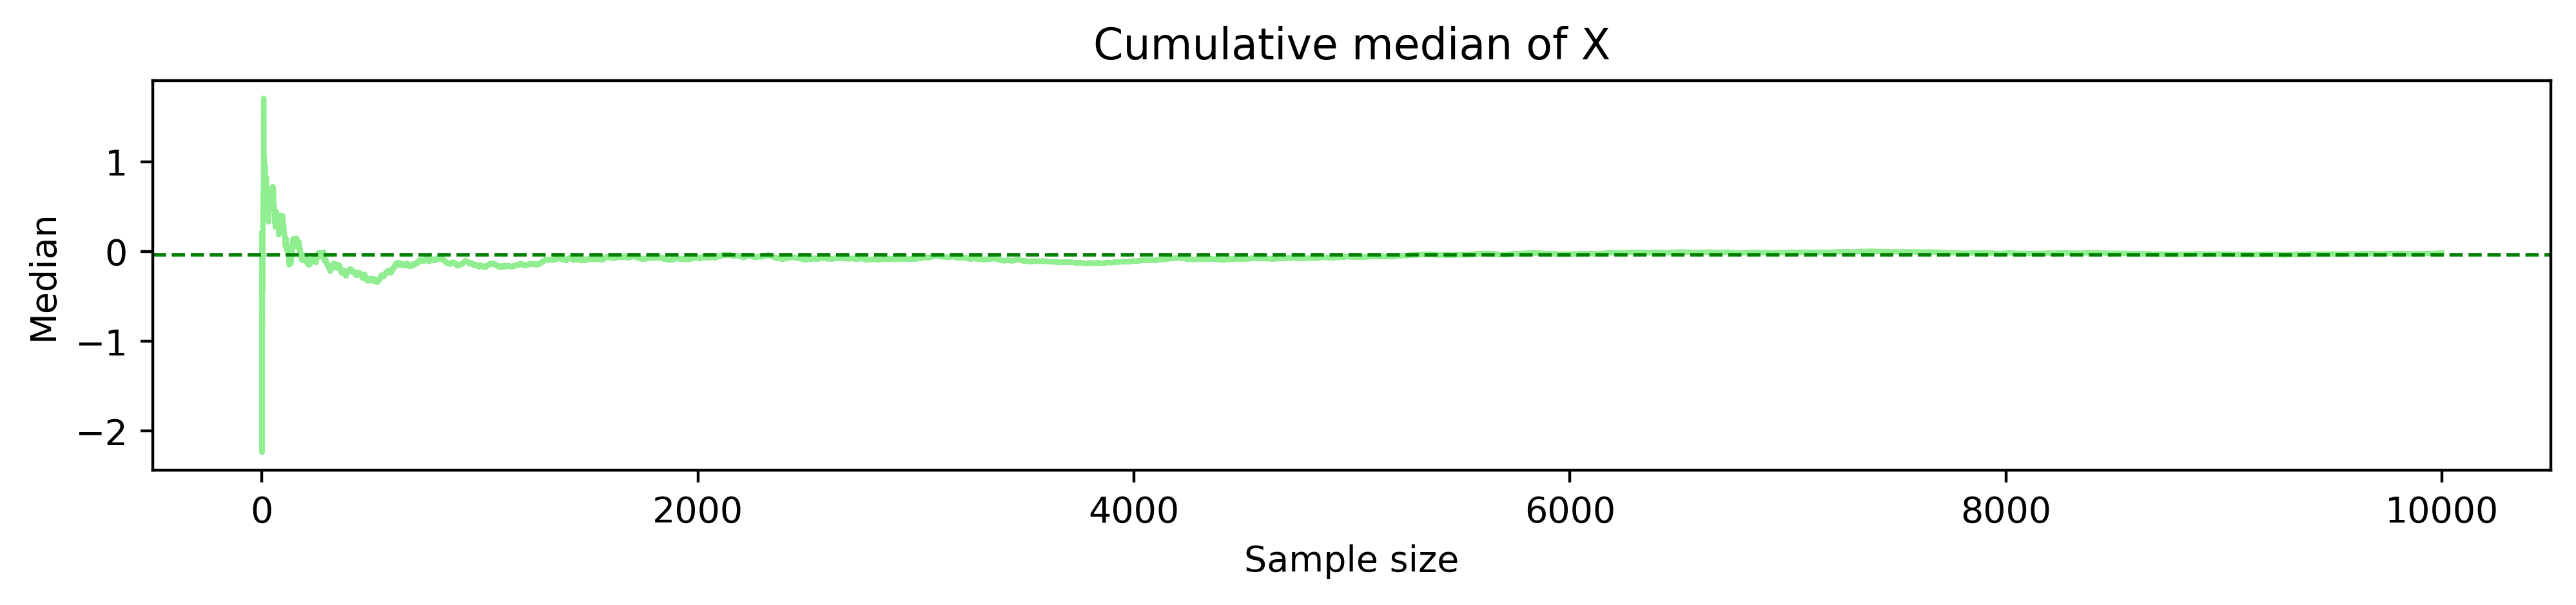

In [81]:
# 1. Sample N=10,000 data points from a Gaussian Distribution with parameters μ=0 and σ=4, using the np.random.standard_normal() function. 
# Store your data in a numpy array X
mu = 0
sigma = 4
X = np.random.normal(mu, sigma, 10000)
# 2. Create a figure. Plot the distribution of the data in X
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the distribution of the data in X
ax.hist(X, bins=100, color='lightblue')
ax.set_title('Gaussian Distribution')
ax.set_xlabel('x')
ax.set_ylabel('Samples')
plt.show()

# 3. Compute the cumulative average of the data in X and store it in a numpy array. 
cumulative_average = np.cumsum(X) / (np.arange(len(X)) + 1)

# 4. Compute the cumulative standard deviation of the data in X and store it in a numpy array.
cumulative_std = np.sqrt(np.cumsum((X - np.mean(X))**2) / (np.arange(len(X)) + 1))

# 5. Compute the values of the distribution mean and median 
mean = np.mean(X)
median = np.median(X)

# 6. Create a figure. Plot the cumulative average of the data in X.
# add errorbars to each point in the graph with width equal to the standard error of the mean (the one you computed in point 4).
# Add a horizontal line corresponding to the distribution mean (the one you found in point 5).
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative average of the data in X
ax.plot(cumulative_average, color='lightpink')
ax.axhline(mean, color='red', linestyle='--', linewidth=1, alpha = 0.5)
# add a title to the plot
ax.set_title('Cumulative average of X')
ax.set_xlabel('Sample size')
ax.set_ylabel('Average')
plt.show()

# 7. Compute the cumulative median of X
cumulative_median = np.cumsum(X) / (np.arange(len(X)) + 1)

# 8. Create a figure. Plot the cumulative median of the data in X.
# Add a horizontal line corresponding to the distribution median (the one you found in point 5).
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative median of the data in X
ax.plot(cumulative_median, color='lightgreen')
# add horizontal line corresponding to the distribution median
ax.axhline(median, color='green', linestyle='--', linewidth=1, label='Median')
# add a title to the plot
ax.set_title('Cumulative median of X')
# add x- and y-labels to the plot
ax.set_xlabel('Sample size')
ax.set_ylabel('Median')
plt.show()

**Pareto Distribution** 

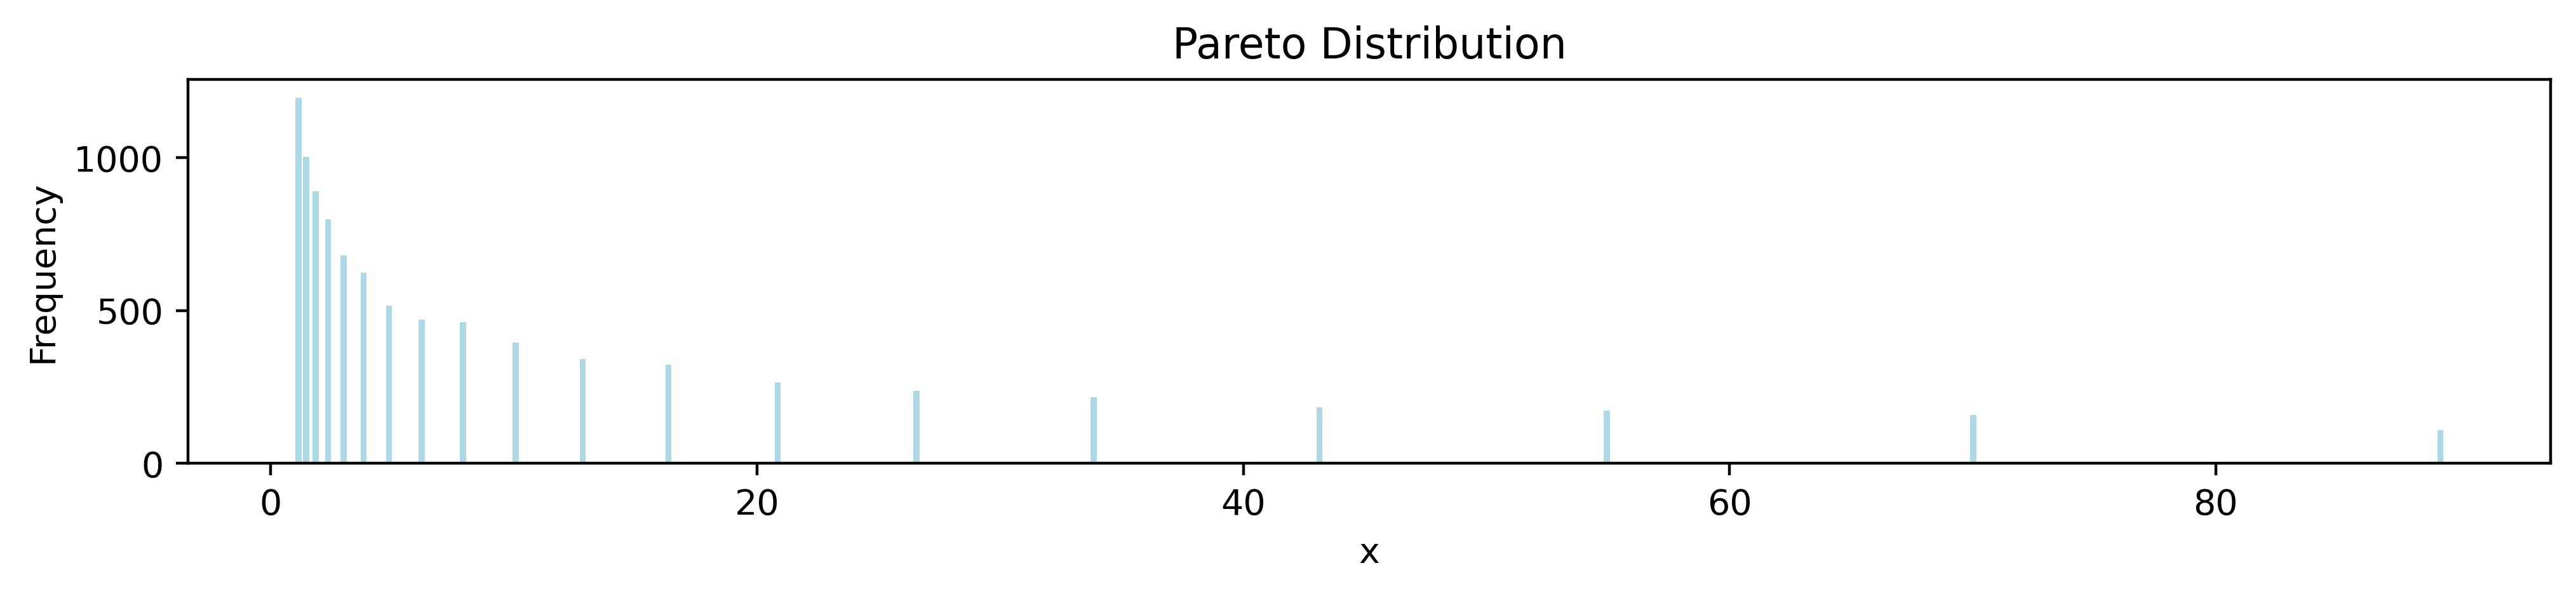

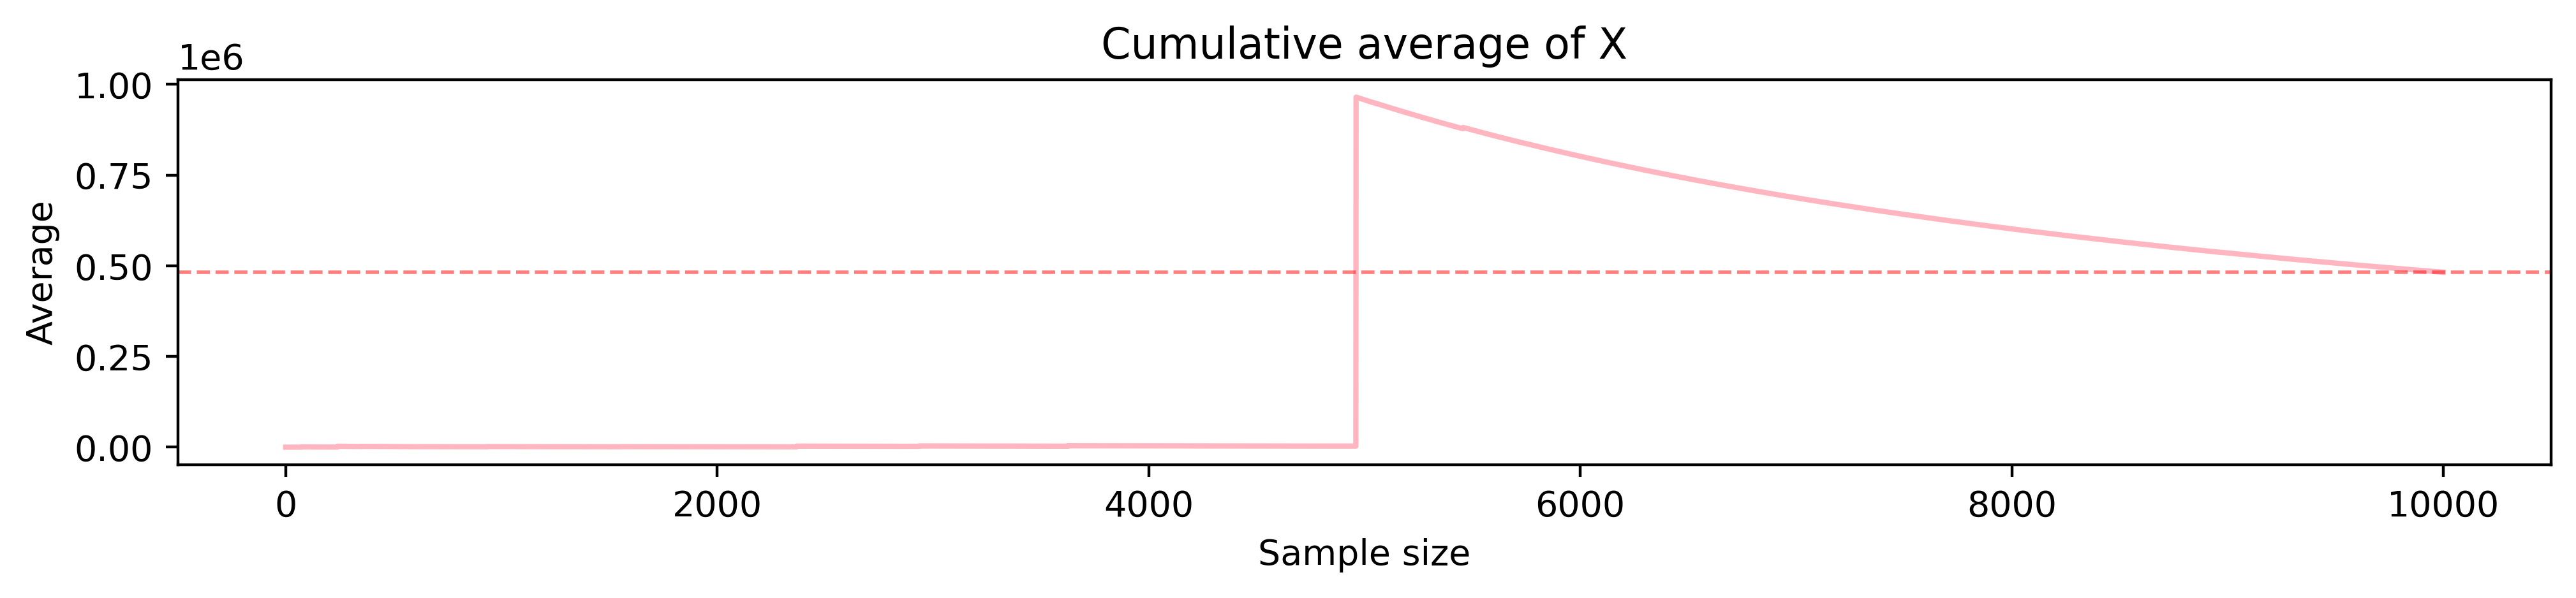

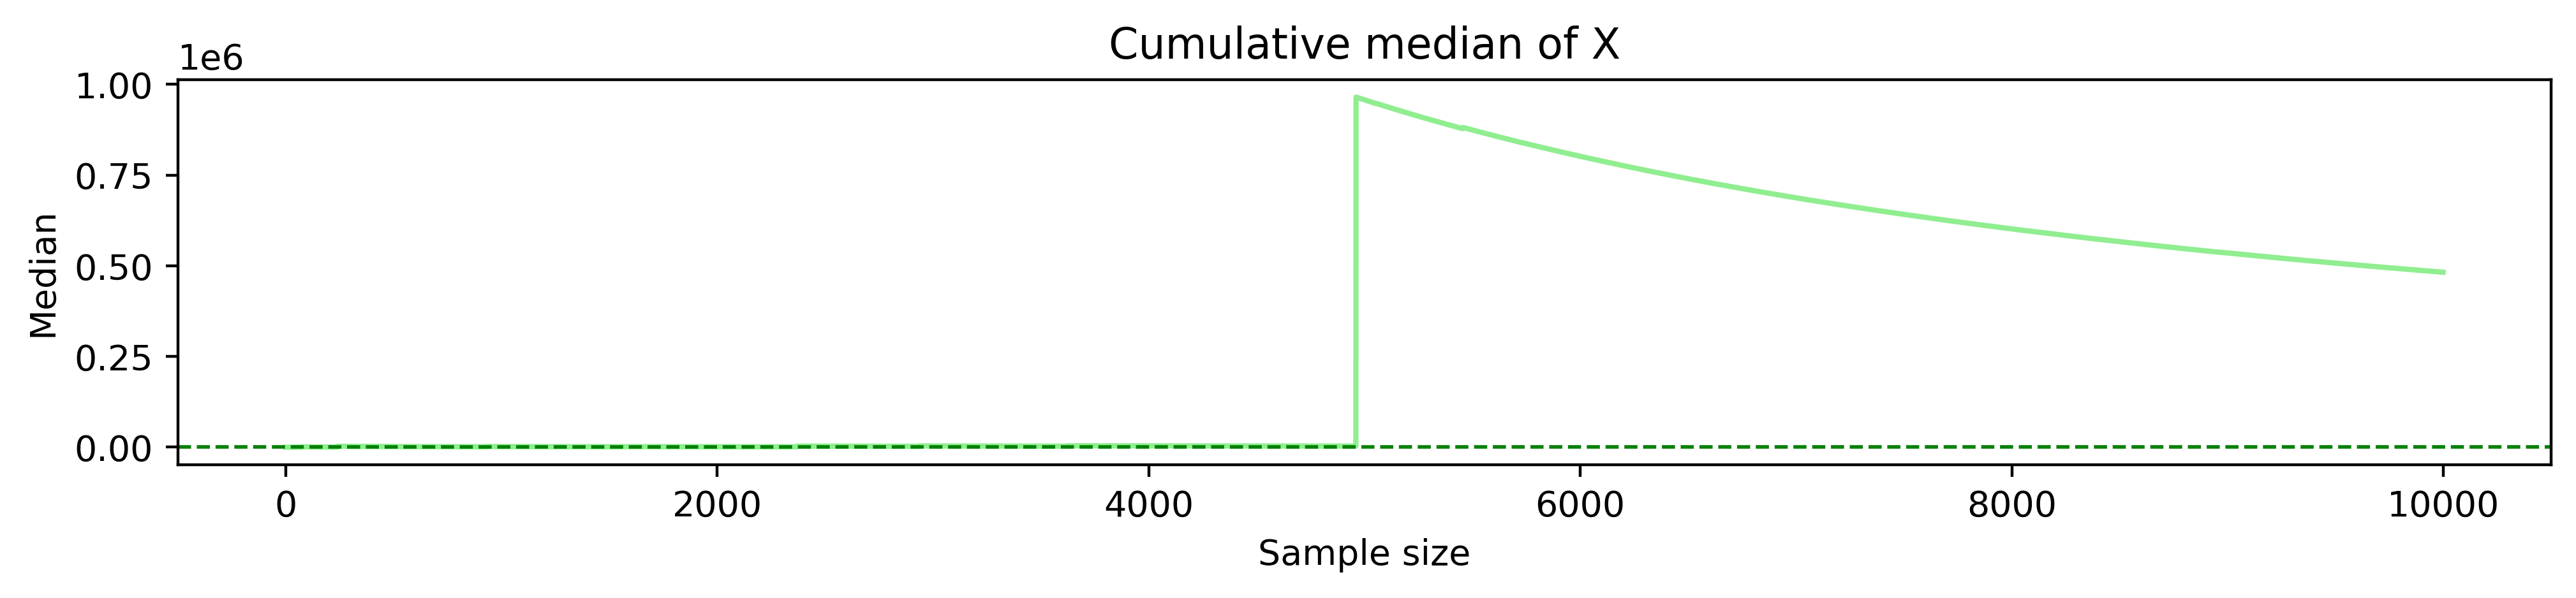

In [82]:
# Repeat for a  Pareto Distribution
x_m = 1
alpha = 0.5

# 1. Sample N=10,000 data points from a Pareto Distribution with parameters x_m=1 and α=0.5, using the np.random.pareto() function.
# Store your data in a numpy array X
X = np.random.pareto(alpha, 10000) + x_m
# print(X)

# 2. Create a figure. Plot the distribution of the data in X

bins = np.logspace(np.log10(1),np.log10(100), 20)
hist, edges = np.histogram(X, bins=bins)
x = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
ax.bar(x, hist, width=width*0.9, color='lightblue')
ax.set_title('Pareto Distribution')
ax.set_xlabel('x')
ax.set_ylabel('Frequency')
plt.show()


# 3. Compute the cumulative average of the data in X and store it in a numpy array.
cumulative_average = np.cumsum(X) / (np.arange(len(X)) + 1)

# 4. Compute the cumulative standard deviation of the data in X and store it in a numpy array.
cumulative_std = np.sqrt(np.cumsum((X - np.mean(X))**2) / (np.arange(len(X)) + 1))

# 5. Compute the values of the distribution mean and median
mean = np.mean(X)
median = np.median(X)


# 6. Create a figure. Plot the cumulative average of the data in X.
# add errorbars to each point in the graph with width equal to the standard error of the mean (the one you computed in point 4).
# Add a horizontal line corresponding to the distribution mean (the one you found in point 5).
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative average of the data in X
ax.plot(cumulative_average, color='lightpink')
ax.axhline(mean, color='red', linestyle='--', linewidth=1, alpha = 0.5)
# add a title to the plot
ax.set_title('Cumulative average of X')
ax.set_xlabel('Sample size')
ax.set_ylabel('Average')
plt.show()

# 7. Compute the cumulative median of X
cumulative_median = np.cumsum(X) / (np.arange(len(X)) + 1)

# 8. Create a figure. Plot the cumulative median of the data in X.
# Add a horizontal line corresponding to the distribution median (the one you found in point 5).
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative median of the data in X
ax.plot(cumulative_median, color='lightgreen')
# add horizontal line corresponding to the distribution median
ax.axhline(median, color='green', linestyle='--', linewidth=1, label='Median')
# add a title to the plot
ax.set_title('Cumulative median of X')
# add x- and y-labels to the plot
ax.set_xlabel('Sample size')
ax.set_ylabel('Median')
plt.show()

**Lognormal Distribution**

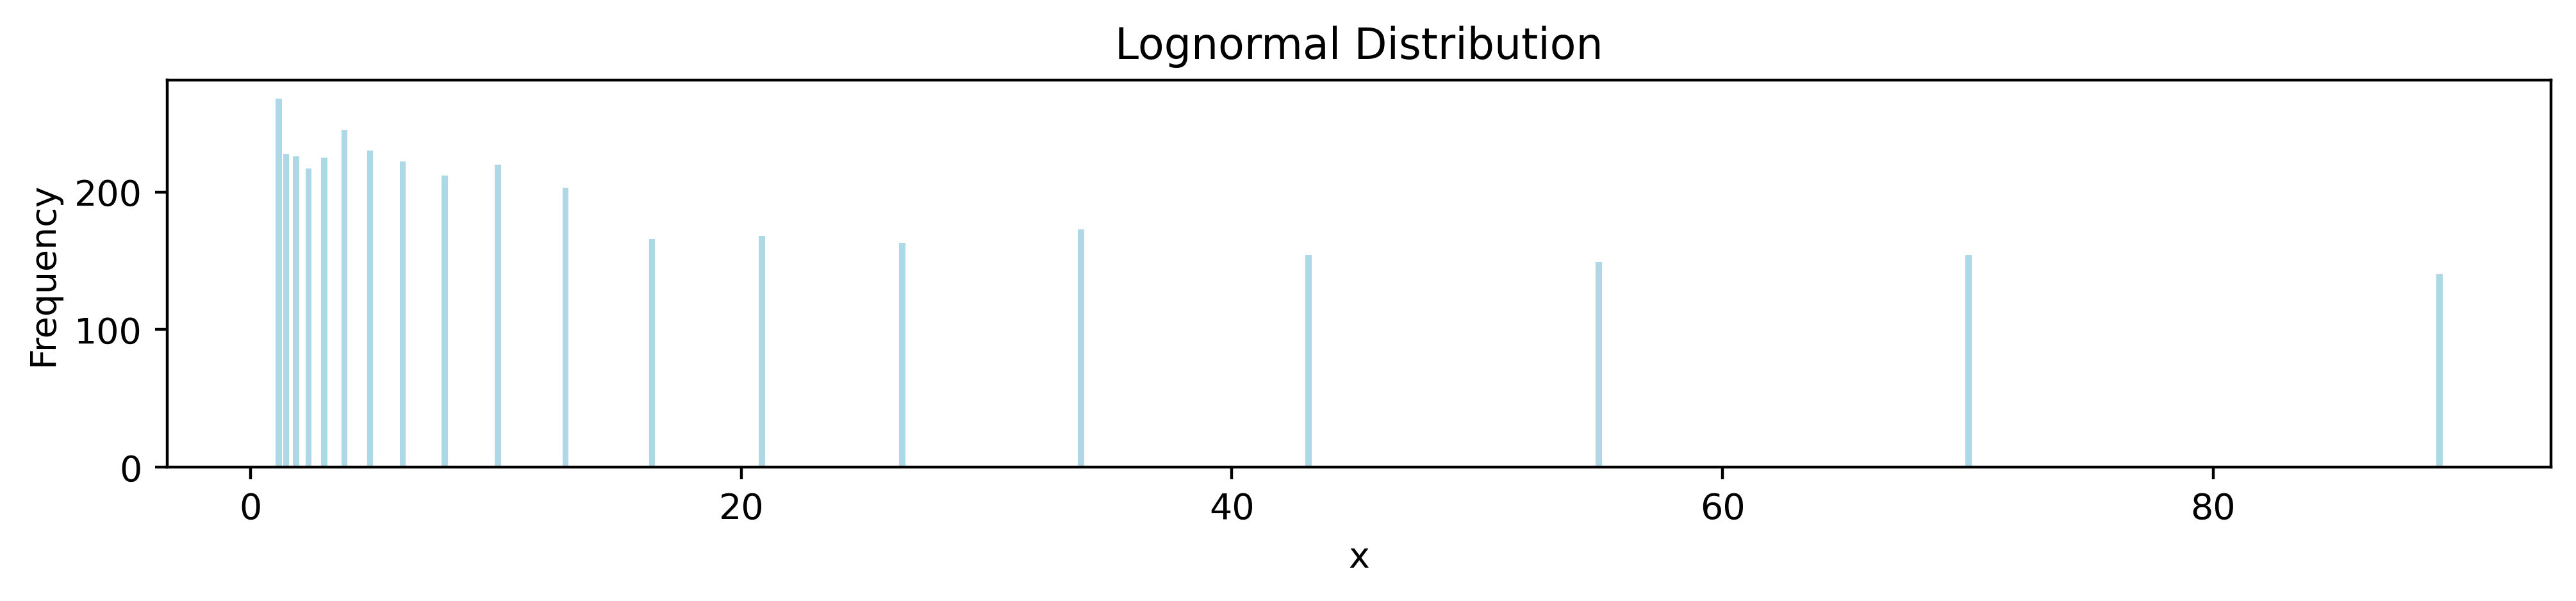

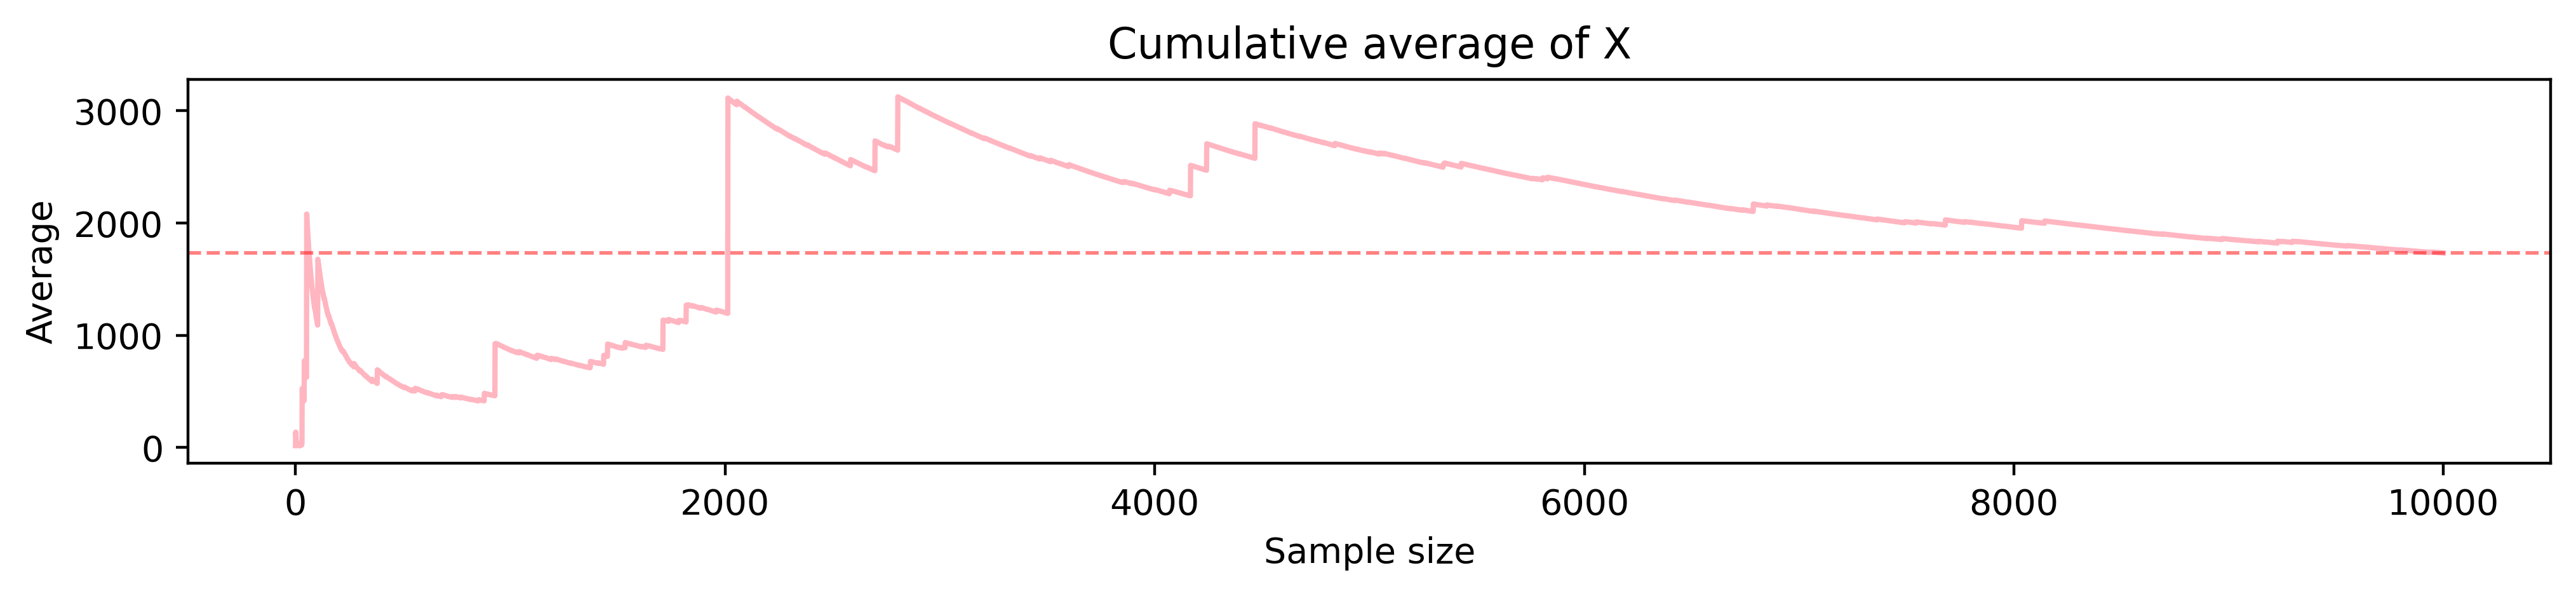

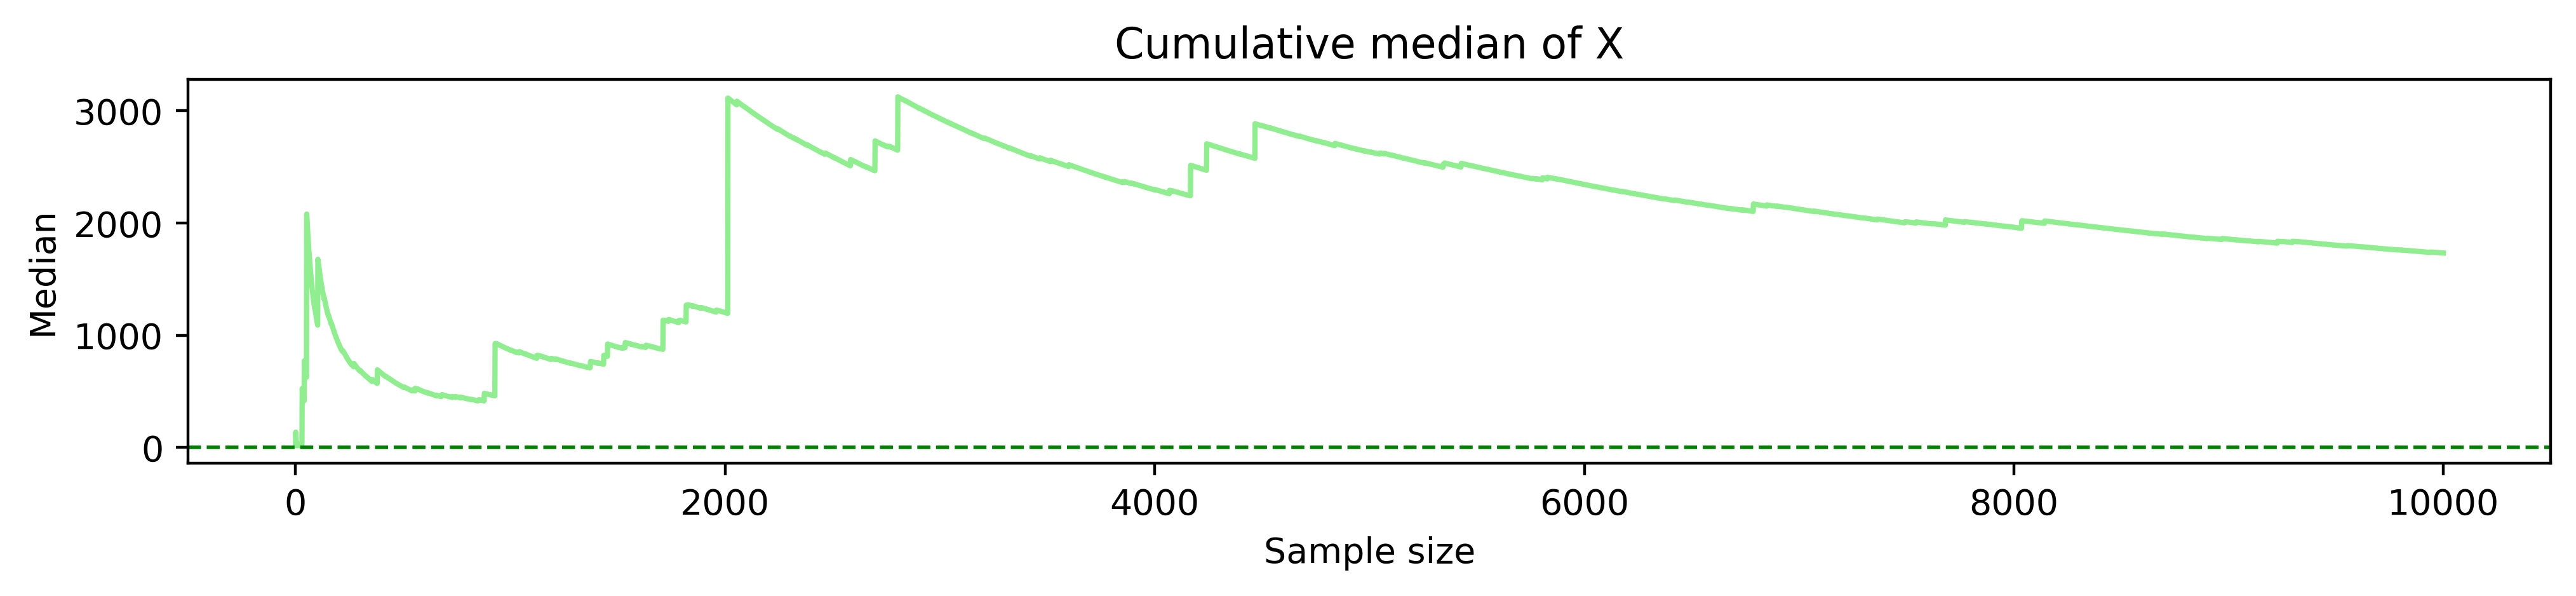

In [83]:
# Repeat for a Lognormal Distribution
mu = 0
sigma = 4

# 1. Sample N=10,000 data points from a Lognormal Distribution with parameters μ=0 and σ=4, using the np.random.lognormal() function.
# Store your data in a numpy array X
X = np.random.lognormal(mu, sigma, 10000)

# 2. Create a figure. Plot the distribution of the data in X
bins = np.logspace(np.log10(1),np.log10(100), 20)
hist, edges = np.histogram(X, bins=bins)
xx = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
ax.bar(xx, hist, width=width*0.9, color='lightblue')
ax.set_title('Lognormal Distribution')
ax.set_xlabel('x')
ax.set_ylabel('Frequency')
plt.show()


# 3. Compute the cumulative average of the data in X and store it in a numpy array.
cumulative_average = np.cumsum(X) / (np.arange(len(X)) + 1)

# 4. Compute the cumulative standard deviation of the data in X and store it in a numpy array.
cumulative_std = np.sqrt(np.cumsum((X - np.mean(X))**2) / (np.arange(len(X)) + 1))

# 5. Compute the values of the distribution mean and median
mean = np.mean(X)
median = np.median(X)

# 6. Create a figure. Plot the cumulative average of the data in X.
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative average of the data in X
ax.plot(cumulative_average, color='lightpink')
ax.axhline(mean, color='red', linestyle='--', linewidth=1, alpha = 0.5)
# add a title to the plot
ax.set_title('Cumulative average of X')
ax.set_xlabel('Sample size')
ax.set_ylabel('Average')
plt.show()

# 7. Compute the cumulative median of X
cumulative_median = np.cumsum(X) / (np.arange(len(X)) + 1)

# 8. Create a figure. Plot the cumulative median of the data in X.
# create a figure
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative median of the data in X
ax.plot(cumulative_median, color='lightgreen')
# add horizontal line corresponding to the distribution median
ax.axhline(median, color='green', linestyle='--', linewidth=1, label='Median')
# add a title to the plot
ax.set_title('Cumulative median of X')
# add x- and y-labels to the plot
ax.set_xlabel('Sample size')
ax.set_ylabel('Median')
plt.show()

**Paper citation counts**

In [84]:
# CITATION COUNT FROM PAPER DATASET FROM 2009
# read the paper dataset
df_paper = pd.read_csv("paper_dataset.csv")
# create an array with all papers from 2009
papers_2009 = df_paper[df_paper["year"] == 2009]
# store the citation count of all papers from 2009 in an array
citation_count_2009 = papers_2009["CitationCount"].values
# print length of papers from 2009
print("The number of papers from 2009 is:", len(papers_2009))

# Compute the mean of the citation count
mean_citation_count_2009 = np.mean(citation_count_2009)
print("The mean of the citation count of papers from 2009 is:", mean_citation_count_2009)
# Compute the median of the citation count
median_citation_count_2009 = np.median(citation_count_2009)
print("The median of the citation count of papers from 2009 is:", median_citation_count_2009)

The number of papers from 2009 is: 5268
The mean of the citation count of papers from 2009 is: 55.87129840546697
The median of the citation count of papers from 2009 is: 11.0


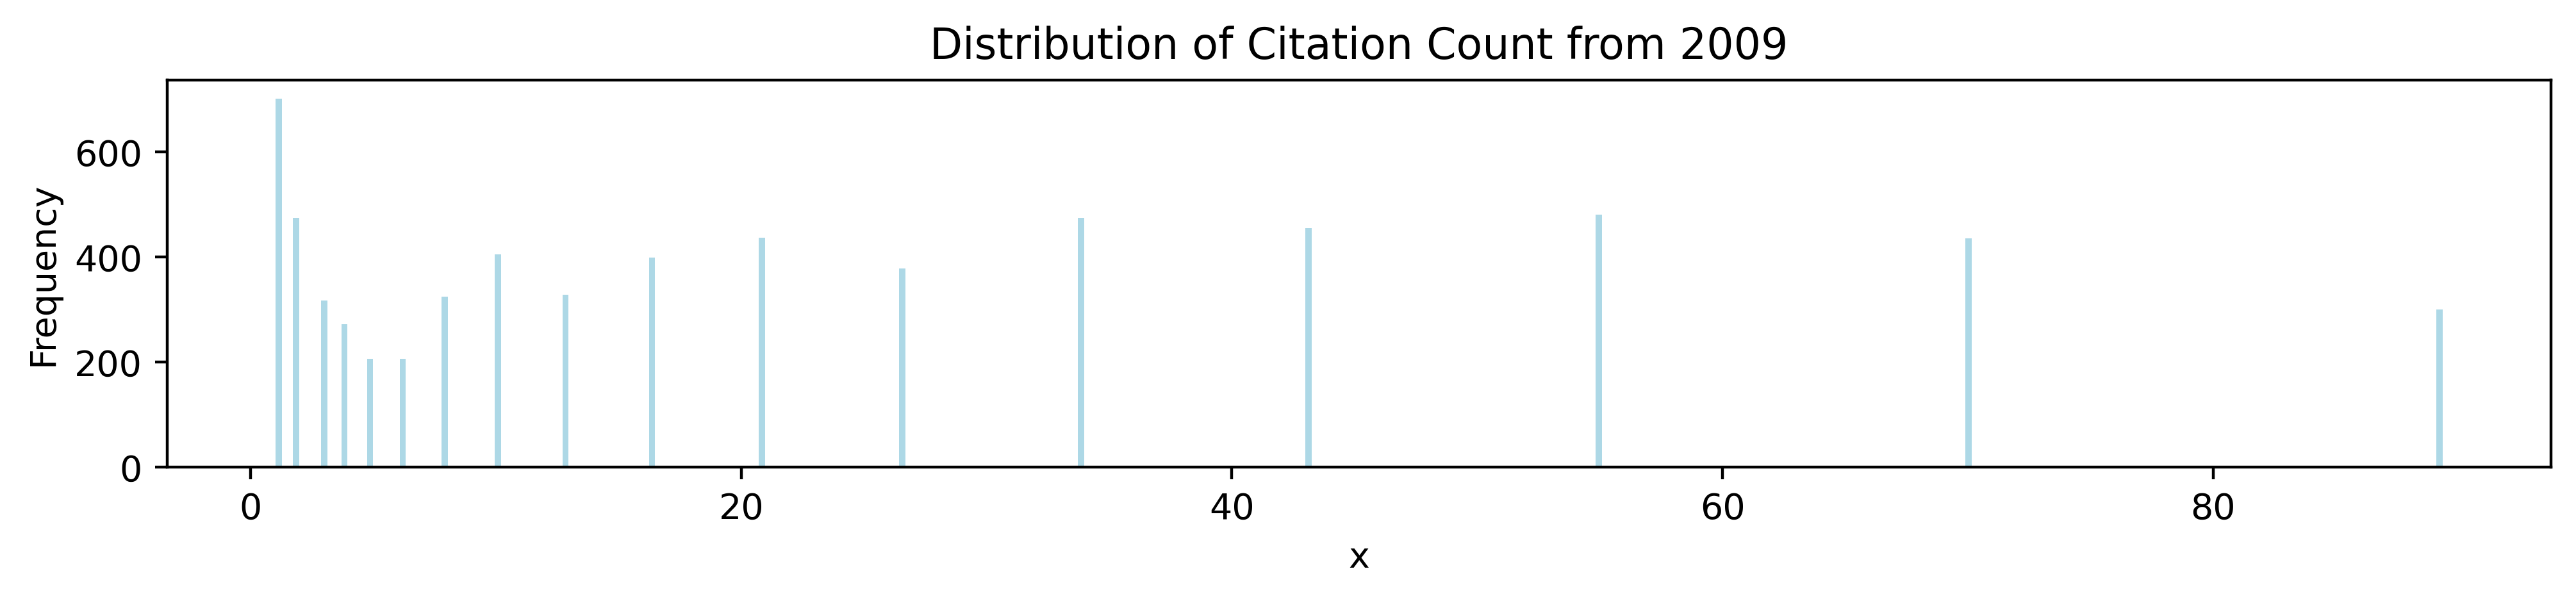

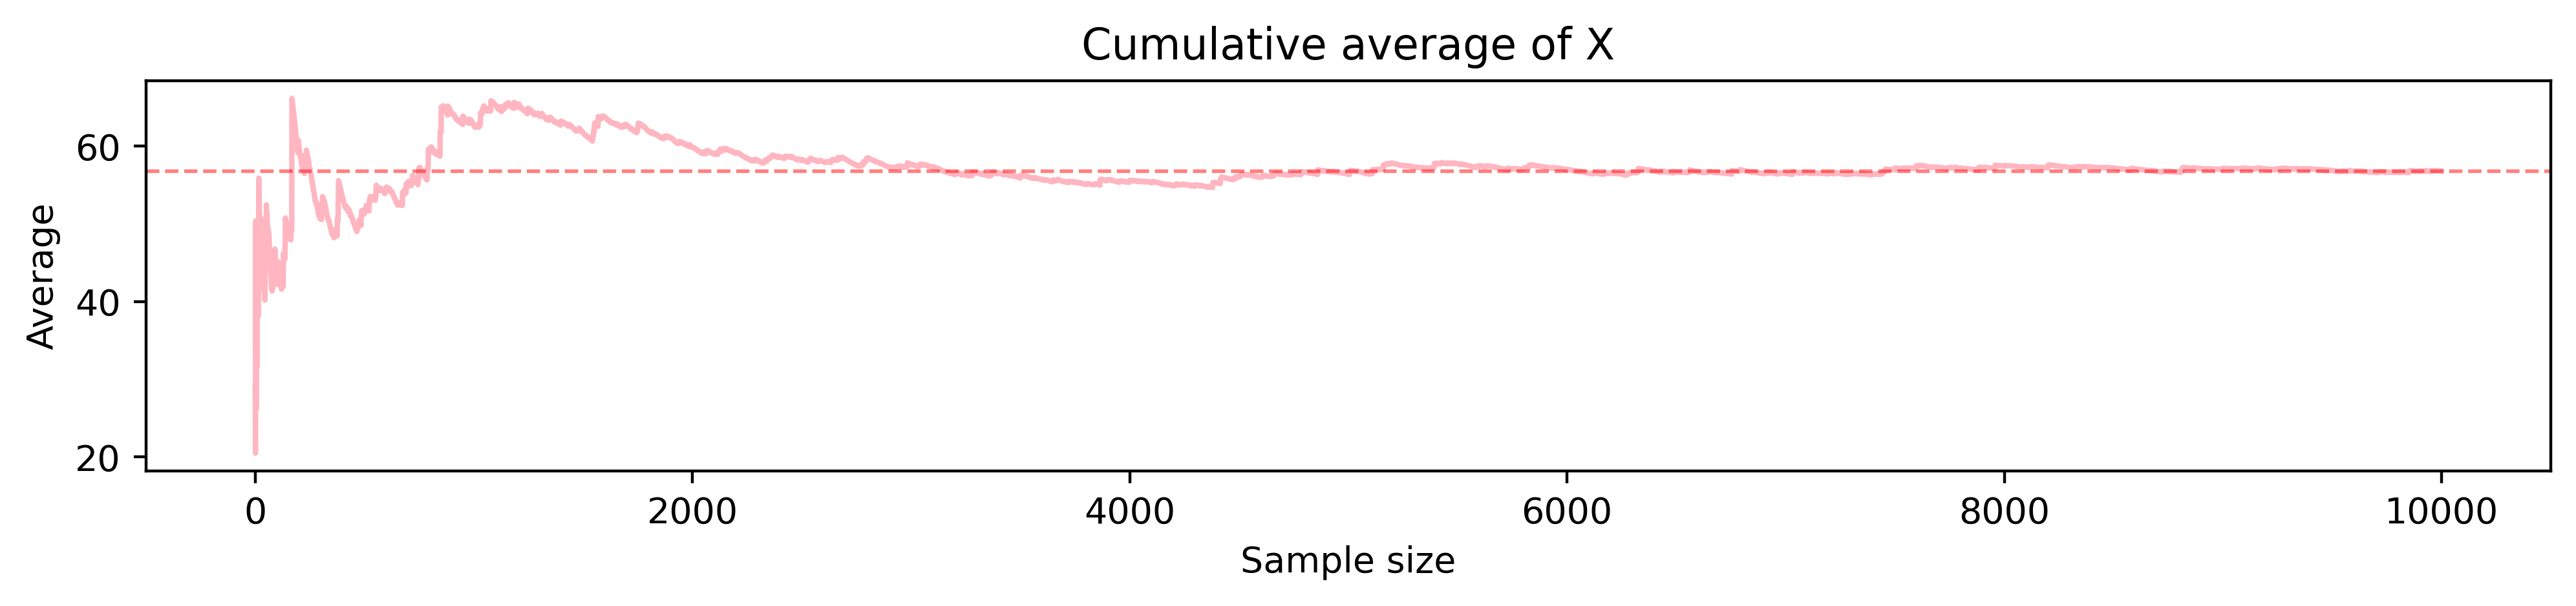

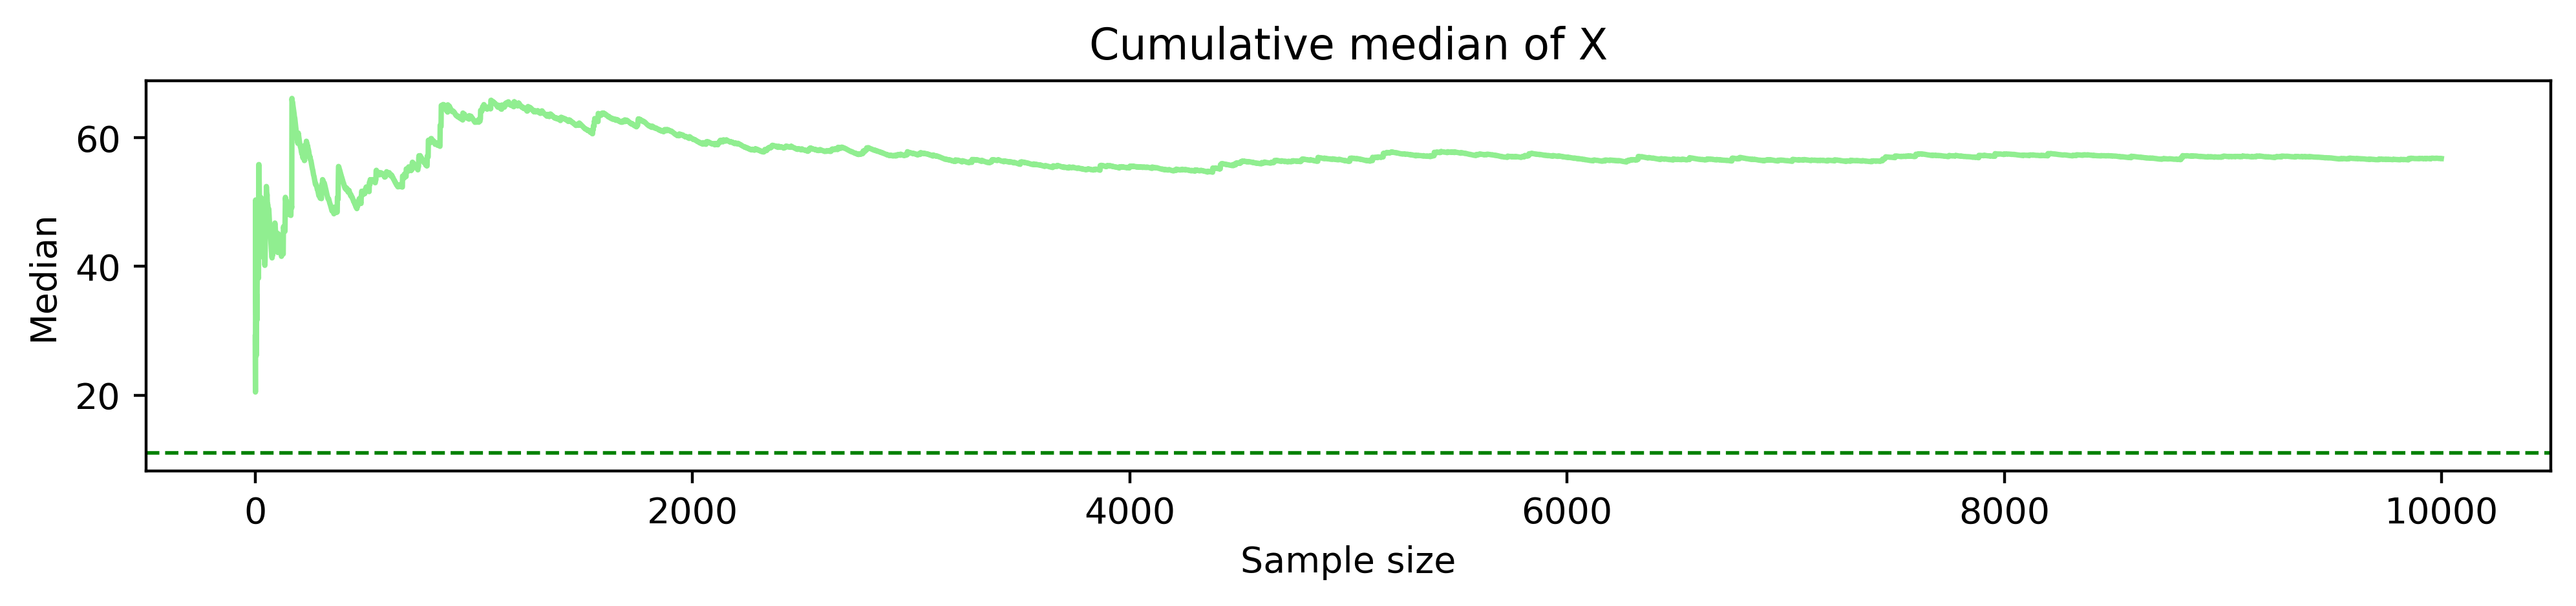

In [85]:
# Create a random sample of 10,000 papers from 2009
X = np.random.choice(citation_count_2009, size=10000)
# X = citation_count_2009

# 2. Create a figure. Plot the distribution of the data in X
bins = np.logspace(np.log10(1),np.log10(100), 20)
hist, edges = np.histogram(X, bins=bins)
xx = (edges[1:] + edges[:-1])/2
width = bins[1] - bins[0]
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
ax.bar(xx, hist, width=width*0.9, color='lightblue')
ax.set_title('Distribution of Citation Count from 2009')
ax.set_xlabel('x')
ax.set_ylabel('Frequency')
plt.show()

# 3. Compute the cumulative average of the data in X and store it in a numpy array.
cumulative_average = np.cumsum(X) / (np.arange(len(X)) + 1)

# 4. Compute the cumulative standard deviation of the data in X and store it in a numpy array.
cumulative_std = np.sqrt(np.cumsum((X - np.mean(X))**2) / (np.arange(len(X)) + 1))

# 5. Compute the values of the distribution mean and median
mean = np.mean(X)
median = np.median(X)

# 6. Create a figure. Plot the cumulative average of the data in X.
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative average of the data in X
ax.plot(cumulative_average, color='lightpink')
ax.axhline(mean, color='red', linestyle='--', linewidth=1, alpha = 0.5)
# add a title to the plot
ax.set_title('Cumulative average of X')
ax.set_xlabel('Sample size')
ax.set_ylabel('Average')
plt.show()

# 7. Compute the cumulative median of X
cumulative_median = np.cumsum(X) / (np.arange(len(X)) + 1)

# 8. Create a figure. Plot the cumulative median of the data in X.
# create a figure
fig, ax = plt.subplots(figsize=(12,2), dpi=400)
# plot the cumulative median of the data in X
ax.plot(cumulative_median, color='lightgreen')
# add horizontal line corresponding to the distribution median
ax.axhline(median, color='green', linestyle='--', linewidth=1, label='Median')
# add a title to the plot
ax.set_title('Cumulative median of X')
# add x- and y-labels to the plot
ax.set_xlabel('Sample size')
ax.set_ylabel('Median')
plt.show()

*1. Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?*

Based on the plots of the cumulative average it can be observed that when the sample size increases, the sample mean will converge to the population mean. The Gaussian distribution quickly converges to the "population mean", whereas for both the Pareto and LogNormal distributions it slowly converges to "population mean". 

The Gaussian distribution has a bell-shaped curve, and as a bell-shaped curve is symmetric and has a finite variance, the Gaussian distribution satisfies the conditions required for the central limit theorem to apply. The Pareto and LogNormal distributions have heavy tails and do not satisfy the conditions required for the central limit theorem to apply, leading to slower convergence of the sample mean to the population mean as the sample size increases.

*2. Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases?*

For the Gaussian distribution the cumulative median also converges quickly to the "population median". This is due to the mean and median being equal for a Gaussian distribution. However, for the two other distributions it does not converge to the "population median", which indicates that the median is a poor statistic in these two cases. For distributions with heavy tails the mean and median are not equal. 

*3. Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?*

For the citation count, we can see that it falls under the category "heavy tails distributions". There are few papers with many citations, but many papers with a few citations. 

*4. What do you think are the main take-home message of this exercise?*

The main take-home message of this exercise is that the choice of statistical measures, such as mean or median, should be based on the underlying distribution of the data. Different distributions have different characteristics, and the behavior of statistical measures can vary accordingly. For example, in heavy-tailed distributions, the median may not be a reliable measure of central tendency, and the mean may be heavily influenced by a small number of extreme values. It is important to understand the properties of the data and the appropriate statistical measures to use when interpreting and analyzing the data.